<a href="https://colab.research.google.com/github/wlgml014/bdas_proj-4/blob/main/tsne/012367idAfterAE_PlotExperiment%EC%B0%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
#col = [0,1,2,3,4,5,6,7,8,9,10,11]
#col = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
col = [4,5,6,7,10,11,12,15]
Dos= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/DoS_dataset_pre.csv',usecols=col)
Fuzzy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/Fuzzy_dataset_pre.csv',usecols=col)
Rpm=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/RPM_dataset_pre.csv',usecols = col)
#,usecols = col

In [ ]:
Dataset = pd.concat((Dos, Fuzzy, Rpm))

In [ ]:
Dataset.shape[1]

8

In [ ]:
def sampling_func(data, n_sample):
    np.random.seed(10) #실행할 때마다 동일한 샘플을 추출하기 위해 random seed 고정
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

SampledDataset = Dataset.groupby('Label', group_keys=False).apply(sampling_func, n_sample=3000)

([<matplotlib.patches.Wedge at 0x7f093327e740>,
 [Text(0.7778174593052024, 0.7778174593052023, 'Benign'),
  Text(-0.7778174593052023, 0.7778174593052024, 'Dos'),
  Text(-0.7778174593052025, -0.7778174593052023, 'Fuzzy'),
  Text(0.7778174593052022, -0.7778174593052025, 'Rpm')])

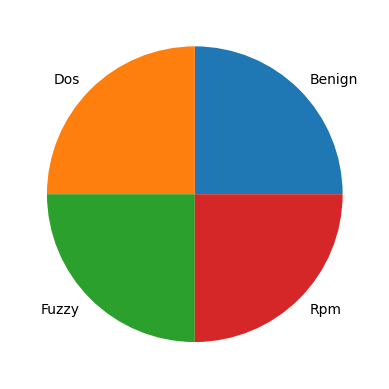

In [ ]:
import matplotlib.pyplot as plt
s = SampledDataset['Label'].value_counts()
plt.pie(s,labels = ['Benign', 'Dos', 'Fuzzy', 'Rpm'])

In [ ]:
X = SampledDataset.drop(['Label'], axis=1)
y = SampledDataset['Label']

In [ ]:
X.shape[1]

7

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train.shape[1]

7

# **AutoEncoder5**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        encoded_X = encoder.predict(X)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded_output = self.autoencoder.layers[-1](decoder_input)  # 마지막 레이어는 디코더 레이어입니다.
        decoder = Model(inputs=decoder_input, outputs=decoded_output)
        decoded_X = decoder.predict(encoded_X)
        return decoded_X

In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 5,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimi  zer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=5, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_test)

75/75 [==============================] - 0s 2ms/step


# **TSNE**

In [ ]:
from sklearn.manifold import TSNE

train_df = encoded_X_train

tsne_np = TSNE(n_components = 2).fit_transform(train_df)

tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

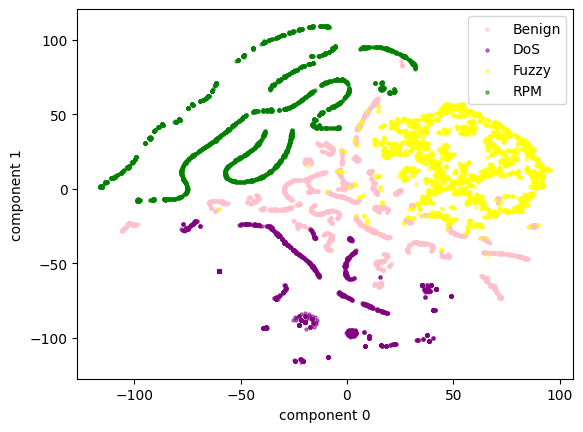

In [ ]:
import matplotlib.pyplot as plt

# class target 정보 불러오기
tsne_df['Label'] = y_train.values

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['Label'] == 0]
tsne_df_1 = tsne_df[tsne_df['Label'] == 1]
tsne_df_2 = tsne_df[tsne_df['Label'] == 2]
tsne_df_3 = tsne_df[tsne_df['Label'] == 3]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'Benign',alpha=0.5, s=5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'DoS', alpha=0.5, s=5)
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'Fuzzy', alpha=0.5, s=5)
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'green', label = 'RPM', alpha=0.5, s=5)

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

train_df = encoded_X_train

tsne_np = TSNE(n_components = 3).fit_transform(train_df)

tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1','component 2'])

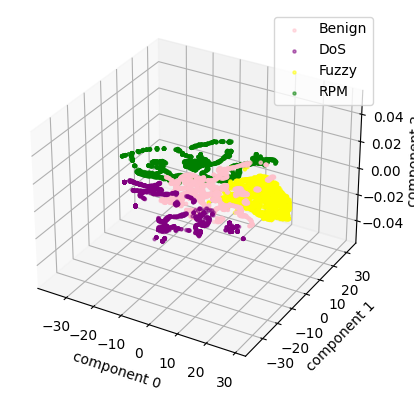

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3차원 시각화 가능
# 3차원 그래프 세팅
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# class target 정보 불러오기
tsne_df['Label'] = y_train.values


# target 별 분리
tsne_df_0 = tsne_df[tsne_df['Label'] == 0]
tsne_df_1 = tsne_df[tsne_df['Label'] == 1]
tsne_df_2 = tsne_df[tsne_df['Label'] == 2]
tsne_df_3 = tsne_df[tsne_df['Label'] == 3]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'Benign',alpha=0.5, s=5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'DoS', alpha=0.5, s=5)
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'Fuzzy', alpha=0.5, s=5)
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'green', label = 'RPM', alpha=0.5, s=5)


ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()